# Transfer learning on swimming pool images

For this project we apply deep learning methods for localizing the object in the image. We are given satellite images of swimming pools. We need to predict the location of these pools on the image. All the images have swimming pools in the center.

## 0. Importing libraries

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pickle

#loading 
from tqdm import tqdm
import os
import cv2

#set seed
import random
random.seed(12345)

#preprocessing data
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

#train test split
from sklearn.model_selection import train_test_split

# building model
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, RandomFlip, RandomRotation, RandomZoom, Resizing, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow_addons as tfa


#estimaing model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

## 1. Loading data

First we load meta data with swimming pool coordinates generated manually by VoTT app. It consist of 4 coordinates for rectangle: `xmin`, `xmax`, `ymin` and `ymax`.

In [2]:
target = pd.read_csv('data/pools-export.csv', index_col = 0)
target.head()

,xmin,ymin,xmax,ymax,label
image,,,,,
42.6342817_2.8647664.png,210.724258,200.748201,285.621122,272.575540,pool
42.6347619_2.8669355.png,222.388489,190.311769,313.247021,279.942446,pool
42.6339681_2.8641433.png,177.573179,151.635510,347.012028,298.359712,pool
42.6342371_2.8637476.png,210.724258,206.273381,274.570762,266.436460,pool
42.634614_2.8724463.png,208.268604,205.045582,285.007194,269.506014,pool


In [3]:
target.shape

(3048, 5)

3k images are not enough to train a neural network with many layers. We will need data augmentation techniques to generate new images.

## 2. Preprocessing data

Before we train the model, we need to transform images into numpy arrays and match them with the metadata of rectangle coordinates.

In [4]:
img_size = 512
path = 'data/train'
X = []
y = []

for img in tqdm(os.listdir(path)):
    img_array = cv2.imread(os.path.join(path, img))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    X.append(img_array)
    
    #normalizing target value
    coord = [target.loc[img, 'xmin'], target.loc[img, 'ymin'], target.loc[img, 'xmax'], target.loc[img, 'ymax']]
    y.append(coord)
    
X = np.array(X)
print("Shape of X: " + str(X.shape))

y = np.array(y)
print("Shape of y: "+str(y.shape))

100%|█████████████████████████████████████████████████████████████████████████████| 3048/3048 [00:29<00:00, 103.83it/s]


Shape of X: (3048, 512, 512, 3)
Shape of y: (3048, 4)


We split data into 3 samples: training, validation and testing. The last one will be used for the final estimation of the model.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1463)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=8293)
print('Train sample size '+ str(len(y_train)))
print('Validation sample size '+ str(len(y_val)))
print('Test sample size '+ str(len(y_test)))

Train sample size 1828
Validation sample size 610
Test sample size 610


Let's save data so we don's waste time to read files in case we rerun the notebook.

In [6]:
np.savez_compressed('data/train', X_train, y_train)
np.savez_compressed('data/val', X_val, y_val)
np.savez_compressed('data/test', X_test, y_test)

## 3. Building model 

We plot some random image with pool rectangle to get idea about the data.

In [7]:
#uncomment in case dat is loaded from the saved files
'''train = np.load('data/train.npz')
X_train, y_train = train['arr_0'], train['arr_1']
val = np.load('data/val.npz')
X_val, y_val = val['arr_0'], val['arr_1']
test = np.load('data/test.npz')
X_test, y_test = test['arr_0'], test['arr_1']'''

"train = np.load('data/train.npz')\nX_train, y_train = train['arr_0'], train['arr_1']\nval = np.load('data/val.npz')\nX_val, y_val = val['arr_0'], val['arr_1']\ntest = np.load('data/test.npz')\nX_test, y_test = test['arr_0'], test['arr_1']"

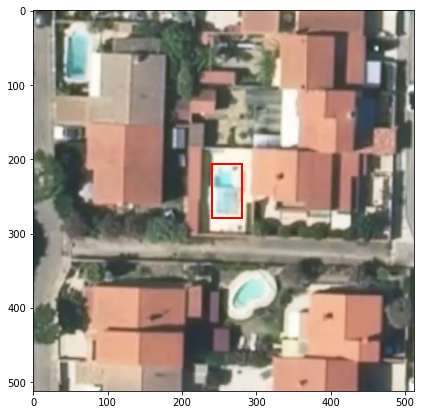

In [8]:
img_size = 512
im_num = np.random.randint(0,len(y_train),1)
img = X_train[im_num][0]
coord = y_train[im_num][0]
fig, ax = plt.subplots(figsize = (7,7))

ax.imshow(img)

rect = patches.Rectangle([coord[0], coord[1]],#xy
                         coord[2]-coord[0], #width
                         coord[3]-coord[1], #height
                         linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

After studying the given data we are going to build model. For this object detection problem are going to use pretrained model vgg16. This way we save time estimating much fewer weights and running fewer epochs. On the top of the vgg16 model we are building new layers which weights will be trained. Apart from dense layers we are also adding a layer with 4 newrons for each rectangle coordinate and a layer which multiplies the coordinates to the image size as sigmoid function returns values in range [0,1].

Apart from pretrained model we are adding some preprocessing layers like resizing, data augmentation which is needed due to small sample size and preprocessing layer zero-centralizing the color channels.

We have 3 layers in `data_augment` layer: flipping, rotating and zooming. All of them are random for better generalization. 

In [9]:
data_augment = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.5),
    RandomZoom(0.1)
])

resize = Resizing(100, 100)

In [10]:
#transfer learning
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(100, 100, 3))
vgg.trainable = False

#preprocessing layers
inputs = Input(shape = (img_size, img_size, 3))
train = resize(inputs)
train = data_augment(train)
train = preprocess_input(train)

#basic model
train = vgg(train, training=False)
flatten = Flatten()(train)
flatten = Dropout(0.1)(flatten)

#top model
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
bboxHead = Lambda(lambda x: x * img_size)(bboxHead)

model = Model(inputs=inputs, outputs=bboxHead)

In [11]:
epochs = 10
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss='mse')
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=50,
    epochs=epochs,
    verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 100, 100, 3)       0         
                                                                 
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 100, 100, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                             

Our model started to converge as the rate of mse change dropped. After training weights for the top of the model, we are unfreezing the whole model and retrain it with very small learning rate value.

In [12]:
epochs = 5 
opt = Adam(learning_rate=1e-5)

vgg.trainable = True

model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=50,
    epochs=epochs,
    verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 100, 100, 3)       0         
                                                                 
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 100, 100, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                             

The final loss we managed to achieve on the validation sample is 223.1786. Let's plot loss for validation and training data to see whether we are overfitting the model or not.

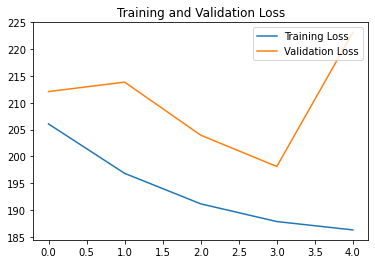

In [13]:
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs_range = range(epochs)

plt.subplot()
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Looks like the model overfit a little over last training and we should have limited number of epochs. Let's save the model and estimate the model on the testing data.

In [14]:
model.save('data/my_model')

INFO:tensorflow:Assets written to: data/my_model\assets


INFO:tensorflow:Assets written to: data/my_model\assets


## 5. Estimating model

To estimate the accuracy of the model we calculate intersection over union score on all the samples.

In [15]:
#uncomment the line below in case model is loaded from the saved file
#model = load_model('data/my_model') 
predictions = model.predict(X_test)
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

print('Train sample IoU score : '+str(1-np.mean(tfa.losses.giou_loss(y_train, train_pred, mode = 'iou'))))
print('Validation sample IoU score : '+str(1-np.mean(tfa.losses.giou_loss(y_val, val_pred, mode = 'iou'))))
print('Test sample IoU score : '+str(1-np.mean(tfa.losses.giou_loss(y_test, predictions, mode = 'iou'))))

20/20 [==============================] - 66s 3s/step
Train sample IoU score : 0.5675653219223022
Validation sample IoU score : 0.569664716720581
Test sample IoU score : 0.5627251267433167


The IoU score is pretty good. Let's plot 10 random images with true and predicted pool coordinates.

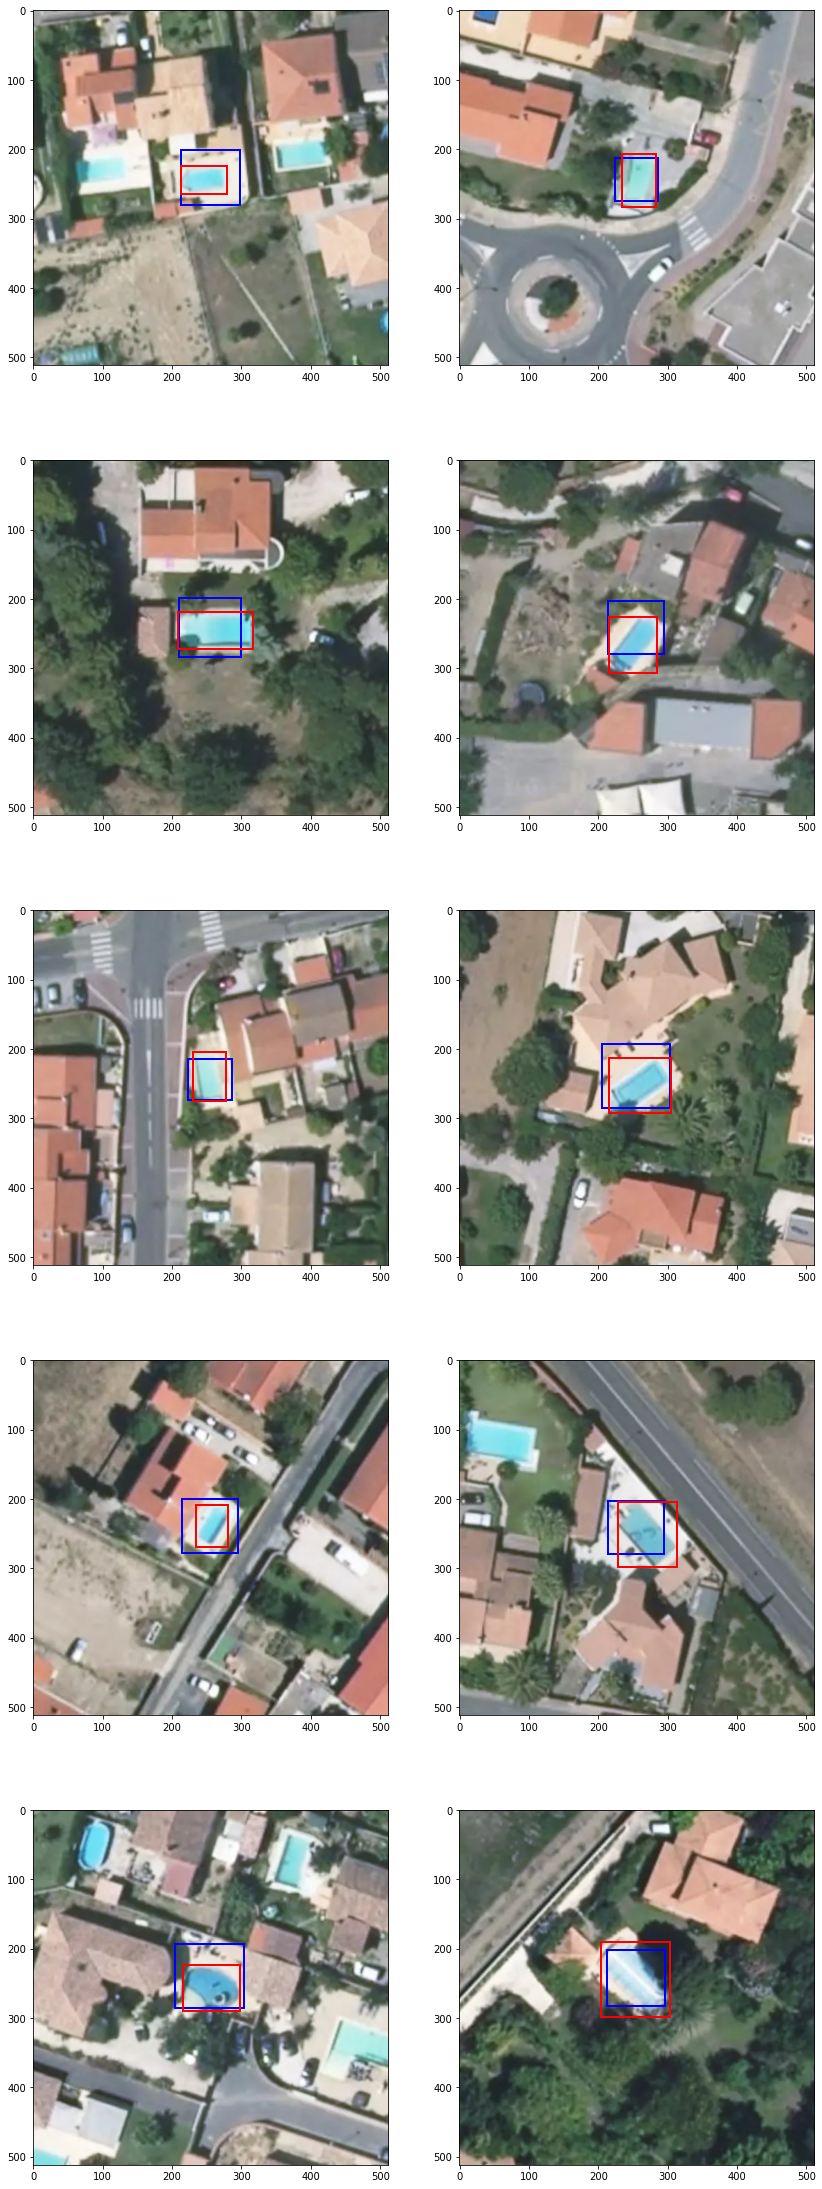

In [16]:
fig, ax = plt.subplots(5,2,figsize = (14,40))
r,c = 0, 0
for i in np.random.randint(0,len(y_test),10):
    img = X_test[i]
    target = y_test[i]
    prediction = predictions[i]
    ax[r,c].imshow(img)

    rect = patches.Rectangle([prediction[0],prediction[1]],
                             prediction[2]-prediction[0],
                             prediction[3]-prediction[1], linewidth=2, edgecolor='blue', facecolor='none')

    # Add the patch to the Axes
    ax[r,c].add_patch(rect)

    rect2 = patches.Rectangle([target[0], target[1]],
                             (target[2]-target[0]),
                             (target[3]-target[1]), linewidth=2, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax[r,c].add_patch(rect2)
    if r==4:
        r=0
        c=1
    else:
        r+=1

plt.show()
    

We can state that the model shows great results on the test sample. In the future we can try solve more complicated problems like detection of all the swimming pools (not only one in the center), prediction of polygon instead of rectangle or detecting other objects on the image like houses (adding classification elements into the model).